In [1]:
# Generation Prediction with Arima

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib.dates import DateFormatter

C:\Users\ava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\ava\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
PV_data = pd.read_csv("miris_pv.csv", parse_dates=['DateTime'], index_col= ['DateTime'])
weather_data = pd.read_csv('weather_data.csv', parse_dates=['Time'], index_col= ['Time'])

In [4]:
PV_data.index = pd.to_datetime(PV_data.index)
weather_data.index = pd.to_datetime(weather_data.index)

In [5]:
print(PV_data.columns)
PV_data = PV_data.reset_index()
PV_data.set_index('DateTime', inplace=True)
PV_df = PV_data.resample('15T').mean()

Index(['PV'], dtype='object')


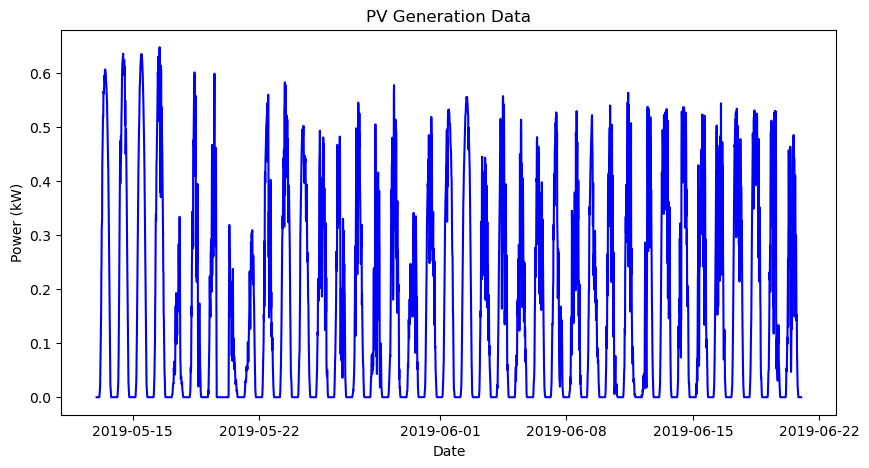

In [7]:
# Plotting PV generation data
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=PV_df, x=PV_df.index, y="PV", ax=ax, color='blue')
ax.set_title("PV Generation Data")
ax.set_xlabel("Date")
ax.set_ylabel("Power (kW)")
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.show()

In [9]:
# filter two datasets to get the same time line

weather_filtered = weather_data.loc['2019-05-14T00:00:00+02:00':'2019-06-18T00:00:00+02:00']
PV_filtered = PV_df.loc['2019-05-14T00:00:00+02:00':'2019-06-18T00:00:00+02:00']

In [30]:
merged_df = pd.concat([PV_filtered, weather_filtered], axis=1)
merged_df.index.name = 'datetime'
merged_df.reset_index(inplace=True)
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])
merged_df = merged_df.set_index('datetime')
merged_df = merged_df.asfreq('15T')
merged_df = merged_df.drop(['SNOW'], axis = 1)
merged_df = merged_df.replace('\u202f', ' ', regex=True)


merged_df['SWDtop'] = merged_df['SWDtop'].str.replace(' ', '').astype(float)



merged_df['PV'].describe()
merged_df.shape

selected_features = ['RH2m','ST','SWDtop', 'SWD']

<AxesSubplot:>

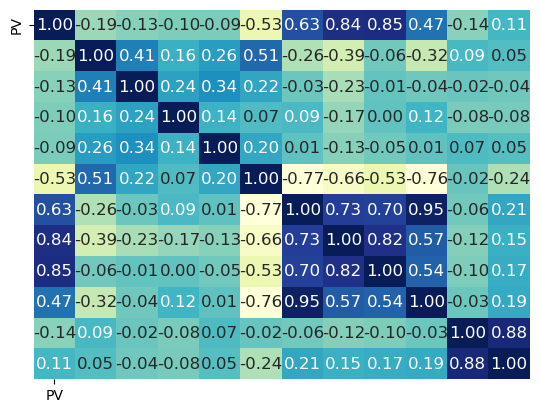

In [31]:
cor = merged_df.corr()
A= cor['PV'].sort_values(ascending= False)
sns.heatmap(cor, cmap="YlGnBu", annot=True, annot_kws={"size": 12}, fmt=".2f", cbar=False, xticklabels=45, yticklabels=45)

In [32]:
train_data, test_data = train_test_split(merged_df, test_size=0.2, shuffle=False)

#train_data.select_dtypes(exclude='number')
#print(train_data['SWDtop'].dtype)
print(np.isfinite(train_data).all())
print(np.isfinite(test_data).all())
test_data.shape
np.log(train_data['PV'])

train_data[selected_features]

PV        True
CD        True
CM        True
CU        True
PREC      True
RH2m      True
ST        True
SWD       True
SWDtop    True
TT2M      True
WS100m    True
WS10m     True
dtype: bool
PV        True
CD        True
CM        True
CU        True
PREC      True
RH2m      True
ST        True
SWD       True
SWDtop    True
TT2M      True
WS100m    True
WS10m     True
dtype: bool


C:\Users\ava\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,RH2m,ST,SWDtop,SWD
datetime,,,,
2019-05-13 22:00:00+00:00,64.23,7.58,0.0,0.0
2019-05-13 22:15:00+00:00,66.35,7.07,0.0,0.0
2019-05-13 22:30:00+00:00,68.59,6.61,0.0,0.0
2019-05-13 22:45:00+00:00,70.89,6.18,0.0,0.0
2019-05-13 23:00:00+00:00,73.26,5.79,0.0,0.0
...,...,...,...,...
2019-06-10 20:45:00+00:00,95.50,13.76,0.0,0.0
2019-06-10 21:00:00+00:00,95.71,13.67,0.0,0.0
2019-06-10 21:15:00+00:00,97.75,14.00,0.0,0.0


In [33]:
# Define the range of p, d, and q values to try
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)

# Create a list of all possible combinations of p, d, and q values
pdq_values = list(itertools.product(p_values, d_values, q_values))

# Define an empty dictionary to store the AIC and BIC values for each model
results = {}
# Loop over all combinations of p, d, and q values
for pdq in pdq_values:
    try:
        # Create an ARIMA model with the current p, d, and q values
        model = ARIMA(train_data['PV'], order=pdq, exog=train_data[selected_features])
        
        # Fit the model to the training data
        model_fit = model.fit()
        
        # Store the AIC and BIC values for the current model in the results dictionary
        results[pdq] = (model_fit.aic, model_fit.bic)
    except:
        continue

# Find the combination of p, d, and q values that results in the lowest AIC value
best_pdq = min(results, key=lambda x: results[x][0])

# Print the best combination of p, d, and q values and the corresponding AIC and BIC values
print(f"Best order: {best_pdq}")
print(f"AIC: {results[best_pdq][0]:.2f}")
print(f"BIC: {results[best_pdq][1]:.2f}")

C:\Users\ava\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ava\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ava\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: No

C:\Users\ava\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ava\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ava\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWa

Best order: (3, 0, 4)
AIC: -8964.89
BIC: -8888.23


In [41]:
#alpha = np.log(train_data['Conso'])
model = ARIMA(train_data['PV'], order=(3, 0, 4), exog=train_data.loc[:, selected_features])
model_fit = model.fit()

In [35]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                     PV   No. Observations:                 2688
Model:                 ARIMA(3, 0, 4)   Log Likelihood                4495.444
Date:                Thu, 23 Mar 2023   AIC                          -8964.887
Time:                        17:29:27   BIC                          -8888.232
Sample:                    05-13-2019   HQIC                         -8937.160
                         - 06-10-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0339      0.050      0.678      0.498      -0.064       0.132
RH2m          -0.0003      0.000     -0.822      0.411      -0.001       0.000
ST            -0.0005      0.002     -0.307      0.7

In [36]:
predictions_train = model_fit.forecast(len(train_data), exog=train_data.loc[:, selected_features], alpha=0.05)
predictions_test = model_fit.forecast(len(test_data), exog=test_data.loc[:, selected_features], alpha=0.05)

# Convert the predictions to a pandas series and set the index to match the original data
#predictions_train = pd.Series(predictions_train, index=train_data.index)
#predictions_test = pd.Series(predictions_test, index=test_data.index)
#predictions_test

predictions_test

2019-06-10 22:00:00+00:00   -0.000576
2019-06-10 22:15:00+00:00   -0.000921
2019-06-10 22:30:00+00:00   -0.000731
2019-06-10 22:45:00+00:00   -0.000208
2019-06-10 23:00:00+00:00    0.000034
                               ...   
2019-06-17 21:00:00+00:00    0.008538
2019-06-17 21:15:00+00:00    0.008667
2019-06-17 21:30:00+00:00    0.008817
2019-06-17 21:45:00+00:00    0.009101
2019-06-17 22:00:00+00:00    0.008588
Freq: 15T, Name: predicted_mean, Length: 673, dtype: float64

In [42]:
rmse_test = mean_squared_error(test_data['PV'], predictions_test, squared=False)

print("RMSE_test:", rmse_test)

RMSE_test: 0.08868548671048022


In [43]:
rmse_train = mean_squared_error(train_data['PV'], predictions_train, squared=False)

print("RMSE_train:", rmse_train)

RMSE_train: 0.0932198757340382


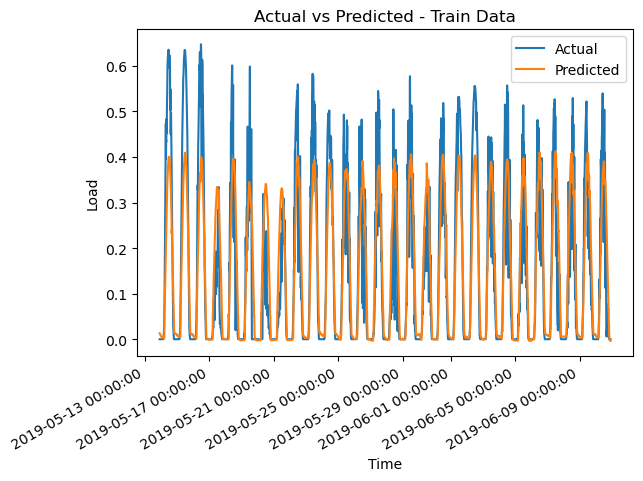

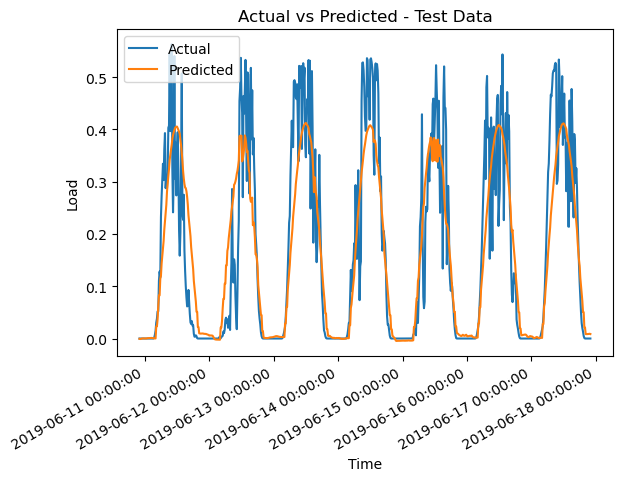

In [39]:
fig, ax = plt.subplots()
ax.plot(train_data.index, train_data['PV'], label='Actual')
ax.plot(train_data.index, predictions_train, label='Predicted')
ax.set_title('Actual vs Predicted - Train Data')
ax.set_xlabel('Time')
ax.set_ylabel('Load')
ax.legend()

# Format the x-axis to display the time stamp
date_form = DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

plt.show()

# plot actual vs predicted values for test data
fig, ax = plt.subplots()
ax.plot(test_data.index, test_data['PV'], label='Actual')
ax.plot(test_data.index, predictions_test, label='Predicted')
ax.set_title('Actual vs Predicted - Test Data')
ax.set_xlabel('Time')
ax.set_ylabel('Load')
ax.legend()

# Format the x-axis to display the time stamp
date_form = DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(date_form)
fig.autofmt_xdate()

plt.show()

In [40]:
# Calculate R-squared for train data
r2_train = r2_score(train_data['PV'], predictions_train)

# Calculate R-squared for test data
r2_test = r2_score(test_data['PV'], predictions_test)

print('R-squared for train data:', r2_train)
print('R-squared for test data:', r2_test)

R-squared for train data: 0.7370972854934699
R-squared for test data: 0.7736937117129701


In [ ]:
merged_df['Conso'].min()